In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Display the first few rows of each dataset
print("Customers Dataset:")
display(customers.head())

print("Transactions Dataset:")
display(transactions.head())


Customers Dataset:


,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


Transactions Dataset:


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


MERGE DATASETS

In [9]:
data = pd.merge(transactions, customers, on='CustomerID')
print("Merged Dataset:")
display(data.head())


Merged Dataset:


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


In [10]:
# Aggregate transaction data by CustomerID
aggregated_data = data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'Price': 'mean'
}).reset_index()

# Rename columns for clarity
aggregated_data.rename(columns={
    'Quantity': 'TotalQuantity',
    'TotalValue': 'TotalSpending',
    'Price': 'AvgPrice'
}, inplace=True)

# Merge aggregated data with customer profiles
final_data = pd.merge(aggregated_data, customers, on='CustomerID')

# Display final dataset for clustering
print("Final Dataset for Clustering:")
display(final_data.head())


Final Dataset for Clustering:


,CustomerID,TotalQuantity,TotalSpending,AvgPrice,CustomerName,Region,SignupDate
0,C0001,12,3354.52,278.334000,Lawrence Carroll,South America,2022-07-10
1,C0002,10,1862.74,208.920000,Elizabeth Lutz,Asia,2022-02-13
2,C0003,14,2725.38,195.707500,Michael Rivera,South America,2024-03-07
3,C0004,23,5354.88,240.636250,Kathleen Rodriguez,South America,2022-10-09
4,C0005,7,2034.24,291.603333,Laura Weber,Asia,2022-08-15


In [11]:
# One-hot encode the Region column
final_data = pd.get_dummies(final_data, columns=['Region'], drop_first=True)

# Drop unnecessary columns (e.g., CustomerName, SignupDate)
final_data.drop(['CustomerName', 'SignupDate'], axis=1, inplace=True)

# Display processed dataset
print("Processed Dataset:")
display(final_data.head())


Processed Dataset:


,CustomerID,TotalQuantity,TotalSpending,AvgPrice,Region_Europe,Region_North America,Region_South America
0,C0001,12,3354.52,278.334000,False,False,True
1,C0002,10,1862.74,208.920000,False,False,False
2,C0003,14,2725.38,195.707500,False,False,True
3,C0004,23,5354.88,240.636250,False,False,True
4,C0005,7,2034.24,291.603333,False,False,False


In [12]:
# Standardize numerical features using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_data.drop('CustomerID', axis=1))

# Convert scaled data back to a DataFrame for easier handling
scaled_df = pd.DataFrame(scaled_data, columns=final_data.columns[1:])
scaled_df['CustomerID'] = final_data['CustomerID']

# Display scaled dataset
print("Scaled Dataset:")
display(scaled_df.head())


Scaled Dataset:


,TotalQuantity,TotalSpending,AvgPrice,Region_Europe,Region_North America,Region_South America,CustomerID
0,-0.122033,-0.061701,0.094670,-0.579284,-0.548319,1.540416,C0001
1,-0.448000,-0.877744,-0.904016,-0.579284,-0.548319,-0.649175,C0002
2,0.203934,-0.405857,-1.094109,-0.579284,-0.548319,1.540416,C0003
3,1.670787,1.032547,-0.447702,-0.579284,-0.548319,1.540416,C0004
4,-0.936951,-0.783929,0.285581,-0.579284,-0.548319,-0.649175,C0005


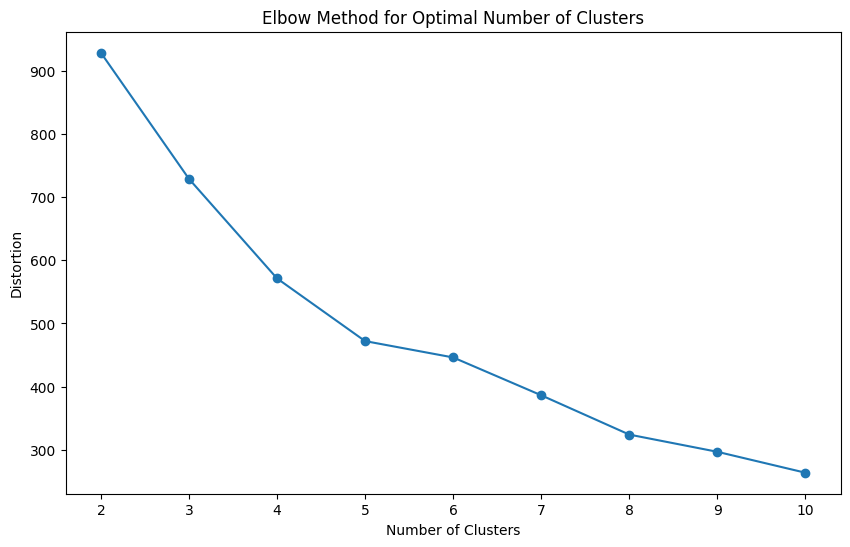

In [13]:
# Determine the optimal number of clusters using the Elbow Method
distortions = []
K = range(2, 11)  # Test clusters from 2 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df.drop('CustomerID', axis=1))
    distortions.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K, distortions, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()


In [29]:
# Fit K-Means with optimal number of clusters (e.g., k=4)
optimal_k = 10 # Replace with your chosen value from the elbow curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
scaled_df['Cluster'] = kmeans.fit_predict(scaled_df.drop('CustomerID', axis=1))
# Display cluster assignments
print("Cluster Assignments:")
display(scaled_df[['CustomerID', 'Cluster']].head())


Cluster Assignments:


,CustomerID,Cluster
0,C0001,9
1,C0002,1
2,C0003,4
3,C0004,8
4,C0005,1


In [30]:
# Calculate Davies-Bouldin Index (DB Index)
db_index = davies_bouldin_score(scaled_df.drop(['CustomerID', 'Cluster'], axis=1), scaled_df['Cluster'])
print(f"Davies-Bouldin Index: {db_index:.2f}")


Davies-Bouldin Index: 1.04


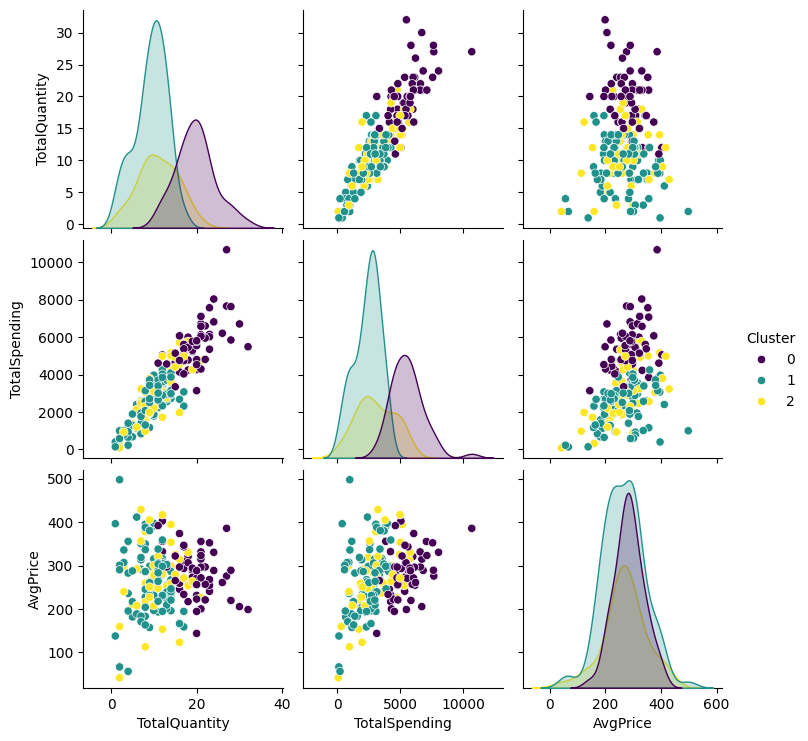

In [16]:
# Add cluster labels to original data for visualization purposes
final_data['Cluster'] = scaled_df['Cluster']

# Pairplot for visualizing clusters (choose key features)
sns.pairplot(final_data, hue='Cluster', vars=['TotalQuantity', 'TotalSpending', 'AvgPrice'], palette='viridis')
plt.show()


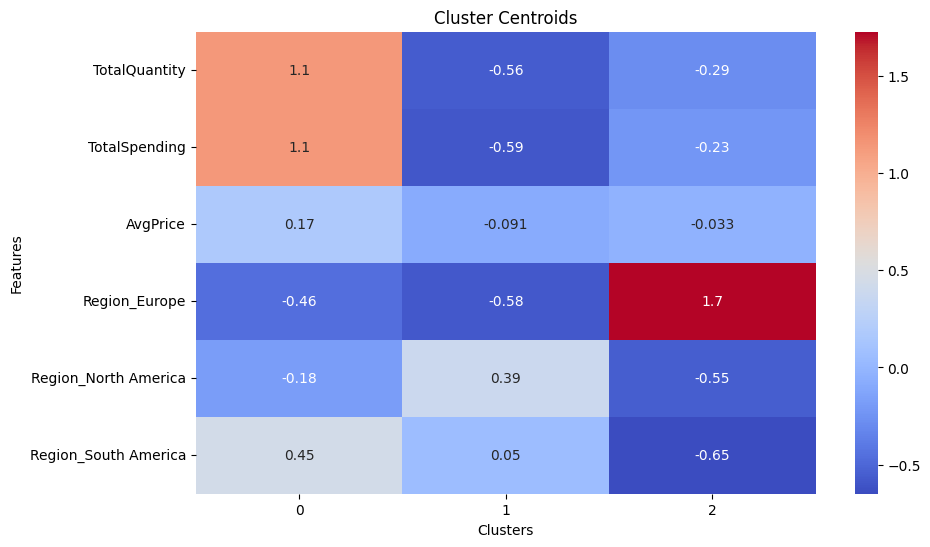

In [17]:
# Calculate cluster centroids for each feature
# Using the original columns from before clustering to avoid the mismatch
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=final_data.drop(['CustomerID', 'Cluster'], axis=1).columns)

# Plot centroids as a heatmap for interpretation
plt.figure(figsize=(10, 6))
sns.heatmap(centroids.T, cmap='coolwarm', annot=True)
plt.title('Cluster Centroids')
plt.xlabel('Clusters')
plt.ylabel('Features')
plt.show()

In [18]:
# Save cluster assignments to a CSV file for submission
scaled_df[['CustomerID', 'Cluster']].to_csv('Clustering_Results.csv', index=False)
print("Clustering results saved to Clustering_Results.csv")


Clustering results saved to Clustering_Results.csv
